В этой части проекта вам нужно написать несколько SQL-запросов в Jupyter Notebook. Эти задания проверят вручную, и вы получите комментарии к составленным запросам.

Необходимые данные находятся в таблицах схемы `stackoverflow`. Не забудьте подключиться к базе с помощью SQLAlchemy. Вспомните инструкцию из урока 11 «Когортный анализ. Представление результатов» в теме 4 «Установка и настройка базы данных и клиента базы данных».. Пример кода для подключения к базе и выгрузки результатов вы найдёте и в этой тетрадке.

Некоторые задания включают дополнительные вопросы — не пропустите их. На часть вопросов можно ответить текстом, а для некоторых понадобится визуализация. Помните, что результат запроса можно выгрузить в датафрейм.

Чтобы ожидаемый результат было легче представить, мы добавили к каждому заданию небольшой фрагмент итоговой таблицы. В запросах вы можете использовать любые подходящие названия полей.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
!pip install -U kaleido

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой мы будем работать в проекте

In [43]:
db_config = {
    'user': 'praktikum_student', # имя пользователя
    'pwd': 'Sdf4$2;d-d30pp', # пароль
    'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net',
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [44]:
engine = create_engine(connection_string)

Пример запроса к базе данных

`sample_df` является pandas-датафреймом.

In [45]:
query = '''
SELECT *
FROM stackoverflow.users
LIMIT 10;
'''

sample_df = pd.read_sql_query(query, con=engine)

In [46]:
sample_df

,id,creation_date,display_name,last_access_date,location,reputation,views
0,1,2008-07-31 14:22:31,Jeff Atwood,2018-08-29 02:34:23,"El Cerrito, CA",44300,408587
1,2,2008-07-31 14:22:31,Geoff Dalgas,2018-08-23 17:31:56,"Corvallis, OR",3491,23966
2,3,2008-07-31 14:22:31,Jarrod Dixon,2018-08-30 20:56:24,"Raleigh, NC, United States",13418,24396
3,4,2008-07-31 14:22:31,Joel Spolsky,2018-08-14 22:18:15,"New York, NY",28768,73755
4,5,2008-07-31 14:22:31,Jon Galloway,2018-08-29 16:48:36,"San Diego, CA",39172,11700
5,8,2008-07-31 21:33:24,Eggs McLaren,2018-04-09 02:04:56,None,942,6372
6,9,2008-07-31 21:35:27,Kevin Dente,2018-08-30 18:18:03,"Oakland, CA",14337,4949
7,11,2008-08-01 00:59:11,Anonymous User,2008-08-01 00:59:11,None,1890,2123
8,13,2008-08-01 04:18:05,Chris Jester-Young,2018-08-30 02:47:23,"Raleigh, NC, United States",177138,35414
9,17,2008-08-01 12:02:22,Nick Berardi,2018-01-22 01:35:38,"Issaquah, WA",44443,4786


# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [47]:
# напишем запрос
query = '''
SELECT CAST(DATE_TRUNC('month', creation_date) AS date) AS month_dt,
       SUM(views_count) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT (YEAR FROM creation_date) = '2008'
GROUP BY month_dt
ORDER BY total_views DESC;
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,month_dt,total_views
0,2008-09-01,452928568
1,2008-10-01,365400138
2,2008-11-01,221759651
3,2008-12-01,197792841
4,2008-08-01,131367083
5,2008-07-01,669895


Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?

По таблице можно сделать вывод, что присутсвует сезонность. В июле, августе и декабре меньше всего просмотров, это связано с тем, что летом и в декабре, у потенциальных пользователей сервиса - студентов, каникулы, а у работающих людей в это время периолд отпусков. Пиковое количество просмотров приходится на сентябрь, что может быть обусловлено началом учебного года, когда одни студенты/ученики создают посты, а другие промсматривают их.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [48]:
# напишем запрос
query = '''
SELECT u.display_name,
       COUNT(DISTINCT p.user_id)
FROM stackoverflow.users u
JOIN stackoverflow.posts p ON u.id = p.user_id
JOIN stackoverflow.post_types pt ON p.post_type_id = pt.id
WHERE p.creation_date::date BETWEEN u.creation_date::date AND u.creation_date::date + INTERVAL '1 month' AND pt.type = 'Answer'
GROUP BY u.display_name
HAVING COUNT(DISTINCT p.id) > 100
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Alan,8
...,...,...
74,lomaxx,1
75,mattlant,1
76,paxdiablo,1
77,tvanfosson,1


Какие аномалии наблюдаются в данных? О чём они говорят?

Тружно сказать наверняка, но высока вероятность, что имя пользователя не обязательно должно быть уникальным, т.к. насчитывается 8 пользователей с именем Alan.

In [49]:
df.query('count != 1').sort_values(by='count', ascending=False).head(10)

,display_name,count
10,Chris,29
45,Matt,29
14,Dan,21
64,Tom,19
41,Mark,17
33,Josh,16
50,Nick,16
7,Brian,15
56,Rob,15
21,Greg,12


Если отбросить уникальные имена пользователей, т.е. отсортировать данные по этому запросу в порядке убывая и вывести топ-10, то можно подвердить ранее сказанную догадку насчет возможности использования разными пользователями одного и того же `user_id`.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [50]:
# напишем запрос
query = '''
SELECT (DATE_TRUNC('month', p.creation_date)::date) AS month_dt,
       COUNT (DISTINCT id)
FROM stackoverflow.posts AS p
WHERE user_id IN (
                  SELECT DISTINCT u.id
                  FROM stackoverflow.users AS u
                  JOIN stackoverflow.posts AS p ON p.user_id = u.id
                  WHERE u.creation_date::date BETWEEN '2008-09-01' AND '2008-09-30'
                    AND p.creation_date::date BETWEEN '2008-12-01' AND '2008-12-31'
                  )
  AND p.creation_date::date BETWEEN '2008-01-01' AND '2008-12-31'
GROUP BY month_dt
ORDER BY month_dt DESC
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,month_dt,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

В августе 2008 года имеется 32 поста, которые создали пользователи, зарегестрировавшиеся в сентябре 2008 года, что очень странно, т.к. данные запрашивались по пользователям, зарегистрированные в сентябре.  
Данная аномалия могла возникнуть из-за сбоя связанного с неверной информацией о часовом поясе, вполне возможно, что эти посты были написаны в сентрябре, либо же пользователи, которые их написали зарегистрировались в августе.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  |
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [51]:
# напишем запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date) AS cumulative_count
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,views_count,cumulative_count
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте.

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [52]:
# напишем запрос
query = '''
SELECT user_id,
       COUNT(id)::numeric / COUNT(DISTINCT creation_date::date) AS avg_daily
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-08-01' AND '2008-08-31'
GROUP BY user_id
HAVING COUNT(id) > 120
ORDER BY avg_daily;
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат.

| result |
| -----  |
| <целое число> |

In [53]:
# напишем запрос
query = '''
WITH t AS(
   SELECT user_id,
          COUNT(DISTINCT creation_date::date) AS days_count
   FROM stackoverflow.posts
   WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
   GROUP BY user_id
)

SELECT ROUND(SUM(days_count) / COUNT(*)) AS result
FROM t;
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

В период с 1 по 7 декабря 2008 года каждый пользователь имел в среднем 2 активных дня.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [54]:
# напишем запрос
query = '''
SELECT user_id,
       creation_date,
       LAG(TO_CHAR(creation_date::date, 'Month'), 2, NULL)
       OVER(PARTITION BY user_id ORDER BY creation_date) AS second_last_month
FROM stackoverflow.posts
ORDER BY user_id, creation_date;
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,user_id,creation_date,second_last_month
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце.

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [55]:
# напишем запрос
query = '''
WITH profile AS(
   SELECT user_id,
          DATE_TRUNC('MONTH', MIN(creation_date))::date AS cohort_dt,
          COUNT(user_id) OVER (PARTITION BY DATE_TRUNC('month', MIN(creation_date))::date) AS cohort_users_cnt
   FROM stackoverflow.posts
   GROUP BY user_id
),
sessions AS(
   SELECT DISTINCT user_id,
                   DATE_TRUNC('month', creation_date)::date AS session_date
   FROM stackoverflow.posts
   GROUP BY 1, 2
)
SELECT cohort_dt,
       session_date,
       COUNT(p.user_id) AS users_cnt,
       cohort_users_cnt,
       ROUND(COUNT(p.user_id) * 100.0 / cohort_users_cnt, 2) AS retention_rate
FROM PROFILE p
JOIN sessions s ON p.user_id = s.user_id
GROUP BY 1, 2, 4
ORDER BY 1, 2;
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

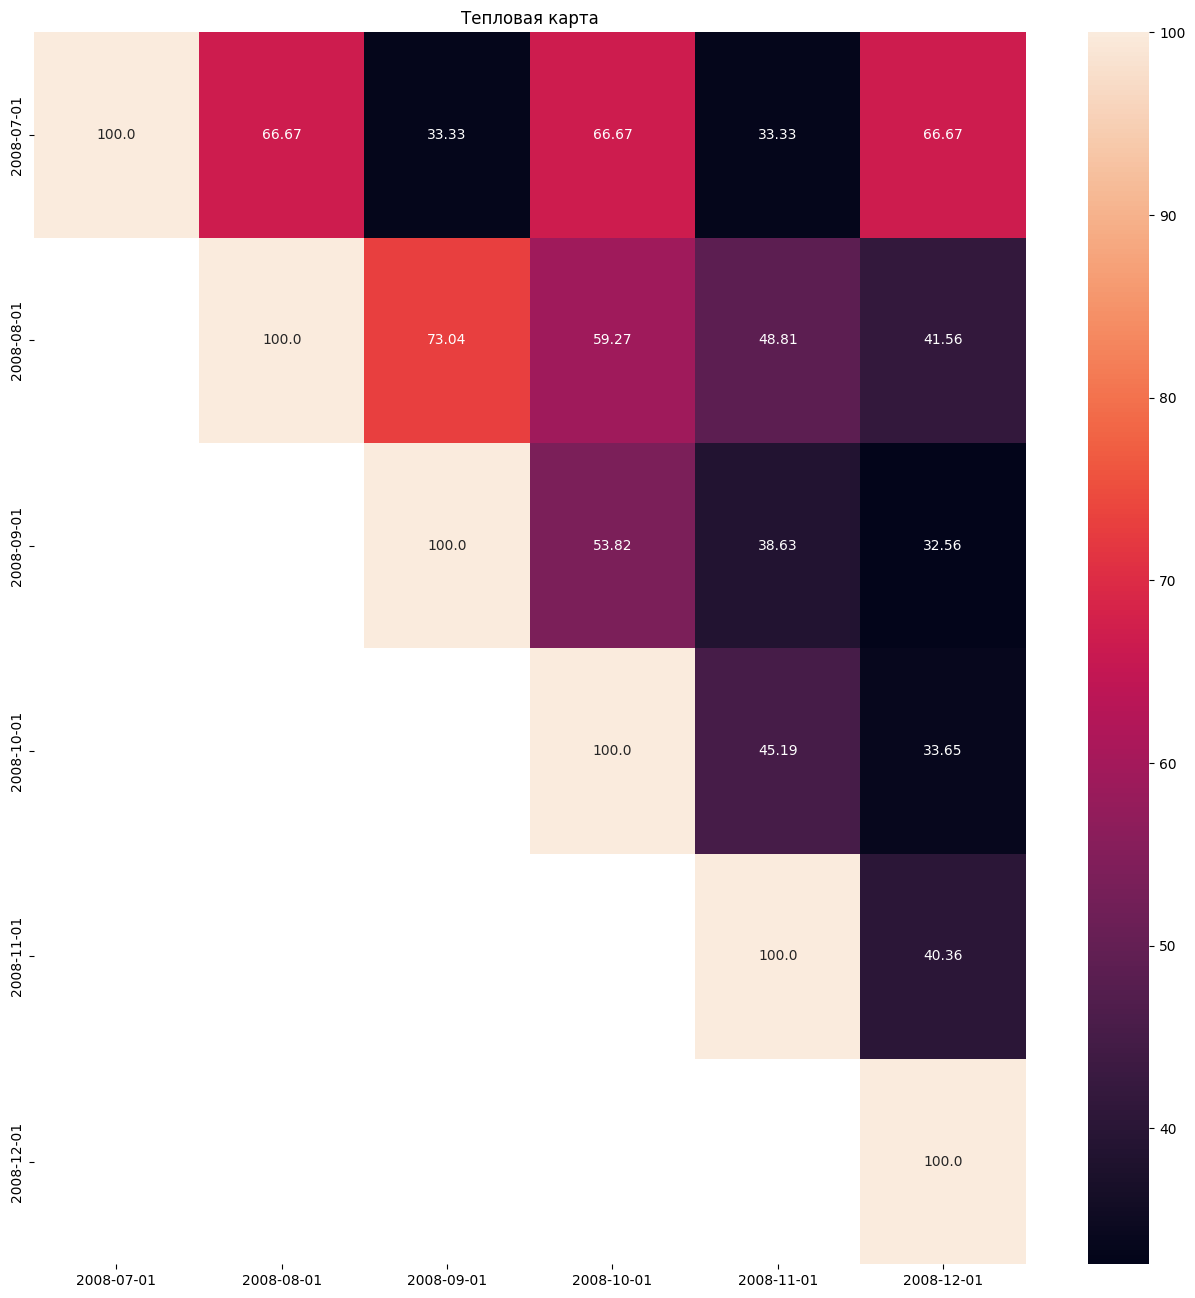

In [56]:
# создаём сводную таблицу с результатами по Retention Rate
retention = df.pivot_table(index='cohort_dt', columns='session_date', values='retention_rate')
retention.index = [str(x)[0:10] for x in retention.index]
retention.columns = [str(x)[0:10] for x in retention.columns]


# строим хитмэп
plt.figure(figsize=(16, 16)) # задаём размер графика
sns.heatmap(retention, # датафрейм с данными
            annot=True, # добавляем подписи
            fmt='') # задаём исходный формат
plt.title('Тепловая карта') # название графика
plt.show()

- В когорте пользователей, пришедших в ноябре, самое маленькое значение Retention Rate за первый месяц.
- В когорте пользователей, пришедших в августе, самый большой показатель Retention Rate за первый месяц.
- Среди когорот пользователей, пришедших в августе и сентябре, коэффициенты удержания первого и второго месяцев лучшие среди всех когорт.
- Августовская когорта имеет лучшие показатели на протяжении 4-х месяцев, что объясняется сезонностью.

Может показаться, что июльская когорта имеет аномальные значения на теплоовой карте, но на самом деле данная выборка просто нерепрезентативна, т.к. в когороте 3 пользователя.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [57]:
# напишите запрос
query = '''
SELECT EXTRACT(MONTH
               FROM creation_date)::integer AS creation_month,
       COUNT(id) AS posts_count,
       ROUND(((COUNT(id)::numeric / LAG(COUNT(id)) OVER()) - 1) * 100, 2) AS percentage
FROM stackoverflow.posts
WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31'
GROUP BY creation_month;
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,creation_month,posts_count,percentage
0,9,70371,NaN
1,10,63102,-10.33
2,11,46975,-25.56
3,12,44592,-5.07


Постройте круговую диаграмму с количеством постов по месяцам.

In [58]:
# построим круговую диаграмму с количеством постов по месяцам
import warnings
warnings.filterwarnings('ignore')

from plotly import graph_objects as go
fig = go.Figure(data=[go.Pie(labels=df['creation_month'], values=df['posts_count'])])
fig.update_layout(title='Количество постов по месяцам',
                 title_x = 0.5,
                 legend=dict(
                 y=1,
                 x=0.8))
for trace in fig.data:
    trace['labels']=['Сентябрь', 'Октябрь', 'Ноябрь', 'Декабрь']
fig.show()

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [59]:
# напишите запрос
query = '''
SELECT DATE_PART('week', creation_date)::integer AS week_creation,
       MAX(creation_date) AS creation_date
FROM stackoverflow.posts
WHERE (creation_date::date BETWEEN '2008-10-01' AND '2008-10-31')
  AND user_id IN
    (SELECT user_id
     FROM stackoverflow.posts
     GROUP BY user_id
     ORDER BY COUNT(id) DESC
     LIMIT 1)
GROUP BY week_creation;
'''

# выполним запрос
df = pd.read_sql_query(query, con=engine)
df

,week_creation,creation_date
0,40,2008-10-05 09:00:58
1,41,2008-10-12 21:22:23
2,42,2008-10-19 06:49:30
3,43,2008-10-26 21:44:36
4,44,2008-10-31 22:16:01
